<a href="https://colab.research.google.com/github/AsmaaIbrahiim/Face-Mask-Detection/blob/model_1/Face_Mask_Detection%7C_Transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

University of Science and Technology, Zewail City <br>
Communications and Information Engineering Program <br>
CIE 555 - Deep Learning and Neural Networks <br>
Course Project - **Face Mask Detection**

# **Imports**

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
# =========================================== #
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten,Dropout
import tensorflow as tf
#============================================== #
import numpy as np
from sklearn.metrics import classification_report
import os

# **Dataset Import**

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1UXAbqllbeh14XslYxAuTOfd3hsvbmp0G'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

#Get random images for testing
#fild_id = '1S2GHYiYFsquDhh1xxLTj_3RtkuXaIvNA'
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('random_images.zip')


In [3]:
!mkdir /content/dataset
!unzip -q /content/archive.zip -d /content/dataset 
#!unzip -q /content/random_images.zip -d /content/random_test_images 

# **Loading data into generators + Helper Functions**

In [4]:
# General Parameters
train_dir='/content/dataset/Face Mask Dataset/Train'
val_dir='/content/dataset/Face Mask Dataset/Validation'
test_dir='/content/dataset/Face Mask Dataset/Test'
random_test_dir = '/content/random_test_images'
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 500

In [5]:
def get_generators(preprocessing_object = tf.keras.applications.vgg19.preprocess_input):
  #preprocessing_function = preprocessing_object,
  train_generator=ImageDataGenerator(
                                    preprocessing_function = preprocessing_object,
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  val_generator=ImageDataGenerator( 
                                    preprocessing_function = preprocessing_object,
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  test_generator= ImageDataGenerator(
                                    preprocessing_function = preprocessing_object)

  ### Generators; train, val and test
  train_data_generator=train_generator.flow_from_directory(train_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')

  val_data_generator=val_generator.flow_from_directory(val_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  test_data_generator=test_generator.flow_from_directory(test_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  return train_data_generator, val_data_generator, test_data_generator

In [6]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [7]:
def load_img_function(img_path, show=True):

    img = load_img(img_path, target_size=(HEIGHT, WIDTH))
    img_tensor = img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return np.vstack([img_tensor])

In [8]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg16.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [9]:
images, labels = next(train_data_generator)

print(images.shape)
print(labels.shape)

(500, 128, 128, 3)
(500, 2)


# **Dataset Visualization**

In [10]:
classes = ['masked','non_masked']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


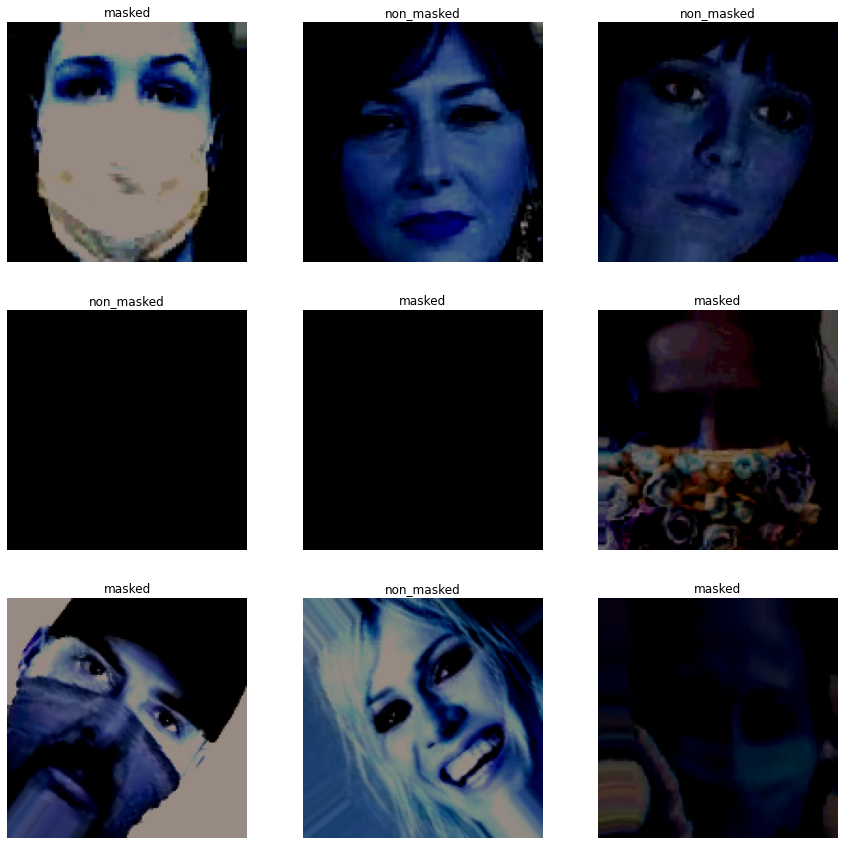

In [11]:
## train
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    images, labels = next(train_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(np.argmax(labels[i]))])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


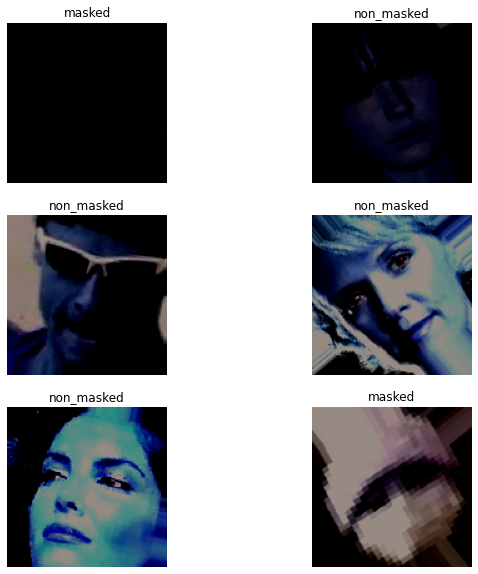

In [12]:
## validation
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    images, labels = next(val_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(np.argmax(labels[i]))])
    plt.axis("off")

# **Models**

*As one of the most popular and effect transfer learning model in use of images, VGG16 model is tried on our dataset.*

## **First Model**: VGG16

**Why it would work?**<br>
VGG16 layers are all convolutional layers with 3x3 kernels and 2x2 max pooling layers untill the 3 final dense layers. Hence, we think that VGG architecture is suitable for capturing small features variantions in the input layer and wider variations in the consecutive layers of the features space. This is practically seems useful as the deeper we go in the images in this project the less important the details are. Also, the input layer for VGG16 is RGB images which is totally important for this project to caputure the mask color variations.

The first trial is just using the pre-trained model with minimum contribution

In [15]:
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers[2:]:
  layer.trainable = False
for layer in base_model.layers[0:2]:
  layer.trainable = True

# Add new classifier layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

**Let's train the model!!**

In [16]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 120s 6s/step - loss: 0.7308 - accuracy: 0.4895 - val_loss: 0.6953 - val_accuracy: 0.5380
Epoch 2/5
20/20 [==============================] - 110s 5s/step - loss: 0.6951 - accuracy: 0.5221 - val_loss: 0.6778 - val_accuracy: 0.5580
Epoch 3/5
20/20 [==============================] - 110s 5s/step - loss: 0.6789 - accuracy: 0.5647 - val_loss: 0.6659 - val_accuracy: 0.5800
Epoch 4/5
20/20 [==============================] - 110s 5s/step - loss: 0.6642 - accuracy: 0.5969 - val_loss: 0.6470 - val_accuracy: 0.6520
Epoch 5/5
20/20 [==============================] - 110s 5s/step - loss: 0.6538 - accuracy: 0.6311 - val_loss: 0.6470 - val_accuracy: 0.6420


The VGG16 model seems promising but relatively slow, hence we're going to raise the learning rate to notice its effect.

In [17]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 115s 6s/step - loss: 0.6216 - accuracy: 0.6679 - val_loss: 0.5371 - val_accuracy: 0.7800
Epoch 2/5
20/20 [==============================] - 110s 5s/step - loss: 0.5299 - accuracy: 0.7852 - val_loss: 0.4629 - val_accuracy: 0.8460
Epoch 3/5
20/20 [==============================] - 110s 5s/step - loss: 0.4617 - accuracy: 0.8379 - val_loss: 0.4081 - val_accuracy: 0.8920
Epoch 4/5
20/20 [==============================] - 110s 5s/step - loss: 0.4071 - accuracy: 0.8823 - val_loss: 0.3860 - val_accuracy: 0.8720
Epoch 5/5
20/20 [==============================] - 110s 5s/step - loss: 0.3719 - accuracy: 0.8917 - val_loss: 0.3562 - val_accuracy: 0.8920


Yes, that's right! The model behaves better with higher learning rate. Let's try the same model with different optimizer (Adam). Also, more layers are included for robustness and somehow avoiding overfitting.

In [18]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 115s 6s/step - loss: 9.6615 - accuracy: 0.5562 - val_loss: 0.3156 - val_accuracy: 0.8500
Epoch 2/5
20/20 [==============================] - 109s 5s/step - loss: 0.2721 - accuracy: 0.8791 - val_loss: 0.1879 - val_accuracy: 0.9220
Epoch 3/5
20/20 [==============================] - 110s 5s/step - loss: 0.1439 - accuracy: 0.9417 - val_loss: 0.1084 - val_accuracy: 0.9600
Epoch 4/5
20/20 [==============================] - 110s 5s/step - loss: 0.0902 - accuracy: 0.9650 - val_loss: 0.0616 - val_accuracy: 0.9700
Epoch 5/5
20/20 [==============================] - 110s 5s/step - loss: 0.0597 - accuracy: 0.9777 - val_loss: 0.0379 - val_accuracy: 0.9900


Adam Optimizer has already boosted the model behavior. The next step is to retrain the model as the final VGG16 model with more epochs.

In [19]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 10,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/10
20/20 [==============================] - 118s 6s/step - loss: 0.8300 - accuracy: 0.6841 - val_loss: 0.1080 - val_accuracy: 0.9560
Epoch 2/10
20/20 [==============================] - 113s 5s/step - loss: 0.0809 - accuracy: 0.9716 - val_loss: 0.0531 - val_accuracy: 0.9840
Epoch 3/10
20/20 [==============================] - 113s 6s/step - loss: 0.0506 - accuracy: 0.9826 - val_loss: 0.0368 - val_accuracy: 0.9840
Epoch 4/10
20/20 [==============================] - 113s 6s/step - loss: 0.0451 - accuracy: 0.9837 - val_loss: 0.0333 - val_accuracy: 0.9880
Epoch 5/10
20/20 [==============================] - 113s 6s/step - loss: 0.0321 - accuracy: 0.9886 - val_loss: 0.0459 - val_accuracy: 0.9860
Epoch 6/10
20/20 [==============================] - 113s 6s/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0331 - val_accuracy: 0.9860
Epoch 7/10
20/20 [==============================] - 113s 6s/step - loss: 0.0228 - accuracy: 0.9914 - val_loss: 0.0143 - val_accuracy: 0.9980
Epoch 8/10
20

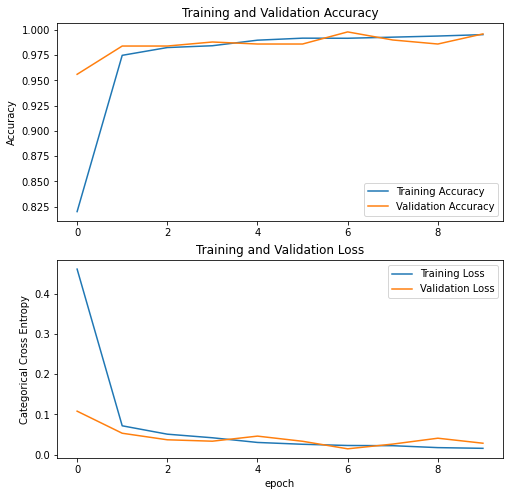

In [20]:
plot_history(history)

### **Model Testing and Evaluation**

In [34]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator, steps=2)

['loss', 'accuracy']
2/2 [==============================] - 4s 1s/step - loss: 0.2731 - accuracy: 0.9929


[0.2731487452983856, 0.992943525314331]

**Let's show the classificaction report (Percision, recall, F1-Score)**

We're more interested in the RECALL metric. This is because the non-maksed class is the TURE (POSITIVE) class and we're concerned with avoiding classifing non-masked as masked. Hence, we're more strict againt FALSE NEGATIVE class. So, RECALL metric is the more important that PRECISION.

In [35]:
# We're testing on 500 images (The generator size)
image_samples, label_samples = next(test_data_generator)
y_pred = np.argmax(model.predict(image_samples), axis=1)
print(classification_report(np.argmax(label_samples, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       236
           1       1.00      0.99      0.99       264

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


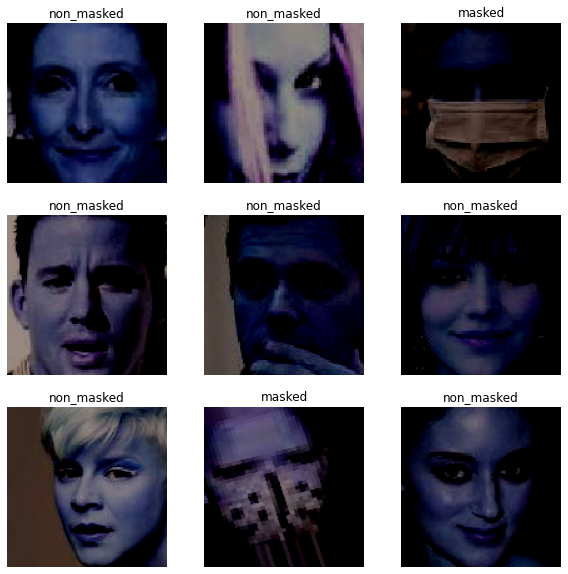

In [36]:
## Testing
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_samples[i]/255);
    plt.title(classes[np.argmax(model.predict(np.expand_dims(image_samples[i], axis=0)))])
    plt.axis("off")

#test_img = image_samples[0]
#x = np.expand_dims(test_img, axis=0)
#plt.imshow(test_img)
#print(classes[np.argmax(model.predict(x))])

### **More Testing**

In [49]:
!mkdir /content/random_images
!unzip -q /content/test.zip -d /content/random_images 

mkdir: cannot create directory ‘/content/random_images’: File exists


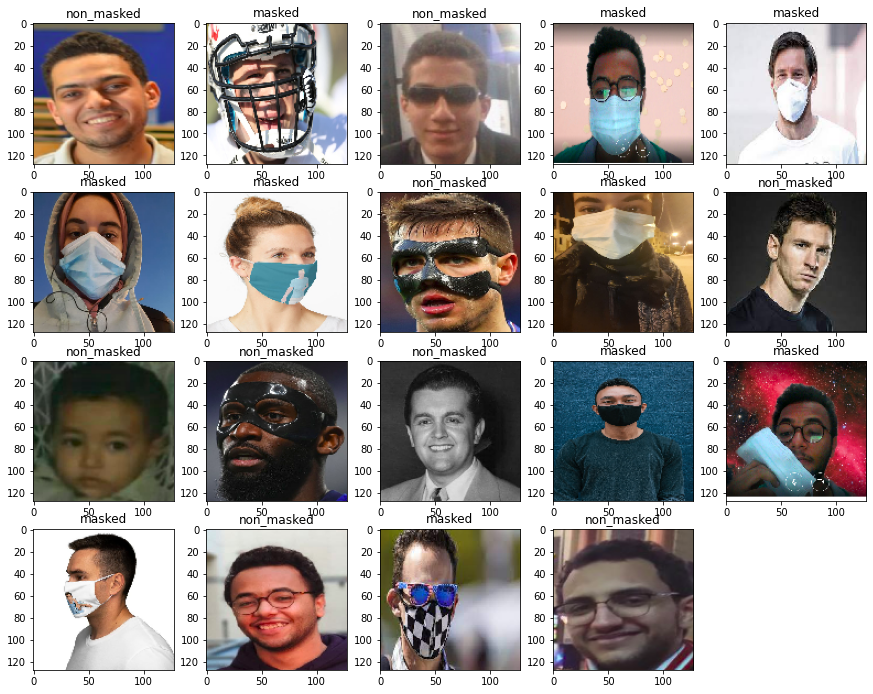

In [50]:
from keras.applications.vgg16 import preprocess_input
plt.figure(figsize=(15, 15))
for i, img_path in enumerate(os.listdir('./random_images')):
  if img_path != '.ipynb_checkpoints':
    ax = plt.subplot(5, 5, i + 1)
    img_path = './random_images/'+img_path
    image = load_img(img_path, target_size=(128, 128))
    plt.imshow(image)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    plt.title(classes[np.argmax(model.predict(image))])

**Last comment about the model:** <br>
1- It behaves very well on the images where only the face is focused on. In general images where the images are not cropped around the face, it makes more mistakes. <br>

**Great! We acheived the required performance with VGG16 model**

In [ ]:
# Save the model!
model.save('fmd_model_vgg16', save_format='h5')

### **Loading the model**

In [ ]:
vgg16_model = keras.models.load_model('fmd_model_vgg16')

In [ ]:
vgg16_model.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  